In [1]:
import torch 
import torch.nn as nn
import torch.optim as opt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader 

In [2]:
import plotly.graph_objects as go 
import numpy as np 
import pandas as pd 

In [3]:
training_filename = 'scenario02-1000000-100-2.csv'
valid_filename = 'scenario02-10000-50-2.csv'
prod_filename  = 'scenario02-10000-100-2.csv'
modeltrained= 'scen02-mem-210907-20-06-4096-ep200'

In [4]:
train = pd.read_csv(training_filename)
valid = pd.read_csv(valid_filename)
prod = pd.read_csv(prod_filename)
train.head()

,pods,file_descriptors,receive_packets,transmit_packets,dropped_packets,cpu_usage_seconds,cpu_throttled_seconds,memory_working_bytes,memory_usage_bytes,load,date
0,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.550171
1,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.602976
2,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.659358
3,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.701646
4,2.0,0.0,0.2,0.0,0.0,0.000128,0.0,0.0,8.0,100,2021-09-06 22:11:42.744043


In [5]:
from sklearn.preprocessing import StandardScaler
def parse_and_standardize(df: pd.DataFrame, scaler: StandardScaler = None):
    df['timestamp'] = pd.to_datetime(df['date'])
    df['stand_value'] = df['memory_working_bytes']
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(df['stand_value'].values.reshape(-1, 1))
    df['stand_value'] = scaler.transform(df['stand_value'].values.reshape(-1, 1))
    return scaler

data_scaler = parse_and_standardize(train)
parse_and_standardize(valid, data_scaler)

parse_and_standardize(prod, data_scaler)

StandardScaler()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
class CPUDataset(Dataset):
    def __init__(self, data: pd.DataFrame, size: int):
        self.chunks = torch.FloatTensor(data['stand_value']).unfold(0, size, size)
        
    def __len__(self):
        return self.chunks.size(0)
    
    def __getitem__(self, i):
        x = self.chunks[i]
        return x

train_ds = CPUDataset(train, 64)
valid_ds = CPUDataset(valid, 64)
prod_ds  = CPUDataset(prod, 64)

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, device):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(in_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        self.device = device
        self.init_hidden()
        
    def forward(self, x):
        out, self.hidden_state = self.lstm(
            x.view(len(x), 1, -1), self.hidden_state
        )
        self.hidden_state = tuple(
            [h.detach() for h in self.hidden_state]
        )
        out = out.view(len(x), -1)
        out = self.linear(out)
        return out
    
    def init_hidden(self):
        self.hidden_state = (
            torch.zeros((1, 1, self.hidden_size)).to(self.device),
            torch.zeros((1, 1, self.hidden_size)).to(self.device))

In [9]:
train_values = train['stand_value'].values.astype(np.float32).flatten()
valid_values = valid['stand_value'].values.astype(np.float32).flatten()

prod_values  = prod['stand_value'].values.astype(np.float32).flatten()

In [10]:
criterion = nn.MSELoss()

In [11]:
model2 = torch.load(modeltrained)

## Evaluation mode

In [12]:
model2.eval()

LSTMModel(
  (lstm): LSTM(1, 4096)
  (linear): Linear(in_features=4096, out_features=1, bias=True)
)

In [13]:
if torch.cuda.is_available():
   model2.cuda()

In [14]:
with torch.no_grad():
    res_train = model2(torch.tensor(train_values).to(device))
res_train = res_train.cpu()

In [15]:
with torch.no_grad():
    res_valid = model2(torch.tensor(valid_values).to(device))
res_valid = res_valid.cpu()

In [16]:
with torch.no_grad():
    res_prod = model2(torch.tensor(prod_values).to(device))
res_prod = res_prod.cpu()

In [17]:
def calculate_prediction_errors(target, predicted, criterion):
    reconstruction_errors = []
    for t, p in zip(target, predicted):
        reconstruction_errors = np.append(
            reconstruction_errors, 
            criterion(p, t).cpu().numpy().flatten()
        )
    return reconstruction_errors

train_pred_errors = calculate_prediction_errors(
    res_train.view(-1), torch.tensor(train_values).view(-1), criterion
)
valid_pred_errors = calculate_prediction_errors(
    res_valid.view(-1), torch.tensor(valid_values).view(-1), criterion
)



prod_pred_errors = calculate_prediction_errors(
    res_prod.view(-1), torch.tensor(prod_values).view(-1), criterion
)

In [18]:
window = 30
std_coef= 4

train_pred_errors_windowed = pd.Series(train_pred_errors).rolling(window=window, min_periods=1)
train_dynamic_threshold = train_pred_errors_windowed.mean() + std_coef * train_pred_errors_windowed.std()

valid_pred_errors_windowed = pd.Series(valid_pred_errors).rolling(window=window, min_periods=1)
valid_dynamic_threshold = valid_pred_errors_windowed.mean() + std_coef * valid_pred_errors_windowed.std()


prod_pred_errors_windowed = pd.Series(prod_pred_errors).rolling(window=window, min_periods=1)
prod_dynamic_threshold = prod_pred_errors_windowed.mean() + std_coef * prod_pred_errors_windowed.std()

In [19]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(
    ground_truth: pd.DataFrame, anomalies_idxs: list
    ):
    predictions = pd.DataFrame(
        index=range(len(ground_truth)), 
        columns=['anomaly_predicted']
    )
    predictions['anomaly_predicted'] = 0
    predictions.iloc[anomalies_idxs] = 1
    
    # Calculation of the confusion matrix can be done using pandas
    confusion_matrix = pd.crosstab(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        margins=True
    )
    precision, recall, f1, _ = precision_recall_fscore_support(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        beta=2., 
        average='binary'
    )
    return confusion_matrix, precision, recall, f1

In [20]:
from typing import Union
def detect_anomalies( result: torch.Tensor, dataset: CPUDataset, threshold: Union[float, pd.Series], n_factors: int = 0):
    anomalies_idxs = []
    for i in range(len(dataset)):
        if type(threshold) == pd.Series:
            is_anomaly = (criterion(result[i], dataset[i]) > threshold[i])
        else:
            is_anomaly = (criterion(result[i], dataset[i]) > threshold)
        if is_anomaly:
            anomalies_idxs.append(i + n_factors)
    return anomalies_idxs

In [21]:
train_anomalies_idxs = detect_anomalies(res_train, torch.tensor(train_values), train_dynamic_threshold)
valid_anomalies_idxs = detect_anomalies(res_valid, torch.tensor(valid_values), valid_dynamic_threshold)

prod_anomalies_idxs  = detect_anomalies(res_prod, torch.tensor(prod_values), prod_dynamic_threshold)

/home/peter/anaconda3/envs/otumba/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [22]:
train_anomalies_idxs 
len(train_anomalies_idxs)

2005

In [23]:
valid_anomalies_idxs
len(valid_anomalies_idxs)

6

In [24]:
prod_anomalies_idxs
len(prod_anomalies_idxs)

0

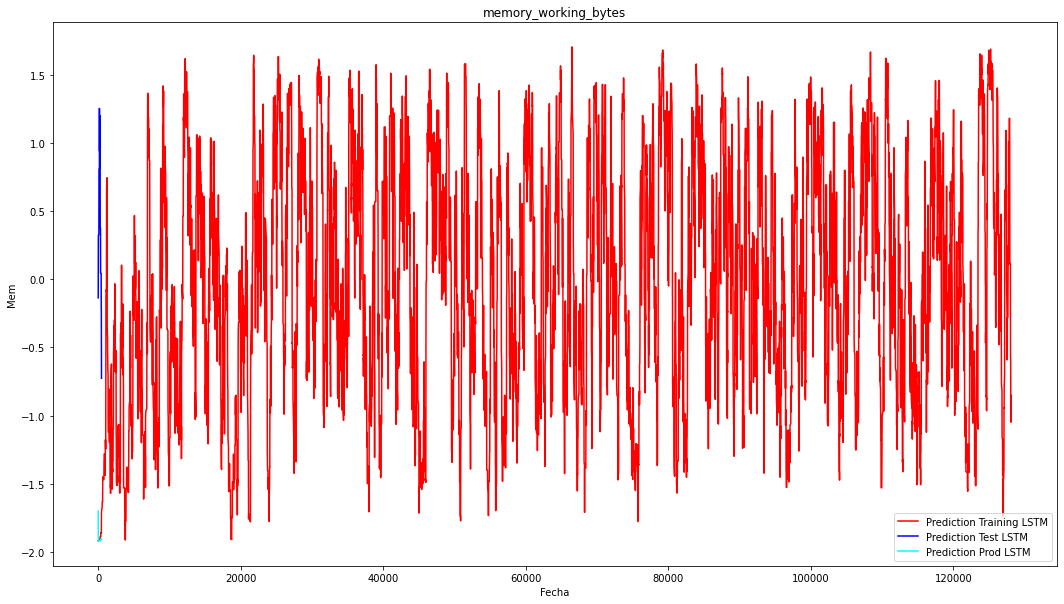

In [25]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(18)
f.set_figheight(10)
plt.plot(res_train, color = 'red', label = 'Prediction Training LSTM')
plt.plot(res_valid, color = 'blue', label = 'Prediction Test LSTM')
plt.plot(res_prod, color = 'cyan', label = 'Prediction Prod LSTM')
plt.title("memory_working_bytes")
plt.xlabel("Fecha")
plt.ylabel("Mem")
plt.legend()
plt.show()

##### 